# Simple use case example of Amazon's Chronos timeseries forecasting package
This notebook demonstrates a very simple use-case of Amazon's Chronos timeseries forecasting model. This model uses LLM architecture and applies it to timeseries forecasting. Pre-trained models are available for download. The model scales and quantizes floating point timeseries data, then tokenizes the binned data to leverage the LLM architecture. Models are pre-trained on publicly available timeseries data and synthesized data.  

Here, I'm downloading stream flow data from the USGS API and attempting to forecast future stream flow values. I'm specifically using the streamflow data from the Snoqualmie River in Snoqualmie, WA (site ID 12144500) since this is a fairly major river that should have fairly strong seasonal flow variations. There do appear to be very large, transient fluctutations due to weather events which will presumably be very difficult for the model to predict without access to weather data. I found that these transients were much larger in smaller tributaries. They would presumably be less prevalent in larger bodies of water (e.g. the Columbia River).

I'm curious how well the model can capture seasonal variations in the data to make future predictions. Given the relatively short context of the model (512 tokens), I suspect that it will likely struggle to leverage the longer-term periodic patterns in the data which is sampled daily. It may be necessary to generate predictions on binned average data over weeks or months to overcome this limitation.

## Imports

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm

from datetime import timedelta

import numpy as np

import seaborn as sns

from chronos import ChronosPipeline
import torch

/home/ubuntu/miniconda/envs/chronos/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions
All functions saved here for convenience

In [11]:
def fetch_usgs_data(site_code, start_date, end_date):
    '''
    Fetch USGS discharge data for a given site and date range.

    Args:
        site_code (str): The USGS site code for the stream gauge
        start_date (str): The start date in the format 'YYYY-MM-DD'
        end_date (str): The end date in the format 'YYYY-MM-DD'

    Returns:
        pd.DataFrame: A DataFrame with the date and discharge in cubic feet per second
    '''
    base_url = "https://waterservices.usgs.gov/nwis/dv/"
    
    params = {
        "format": "json",
        "sites": site_code,
        "startDT": start_date,
        "endDT": end_date,
        "parameterCd": "00060",  # Code for discharge in cubic feet per second
        "siteStatus": "all"
    }
    
    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        
        # Extract time series data
        time_series = data['value']['timeSeries'][0]['values'][0]['value']
        
        # Convert to DataFrame
        df = pd.DataFrame(time_series)
        df['date'] = pd.to_datetime(df['dateTime'])
        df['value'] = pd.to_numeric(df['value'])
        df = df[['date', 'value']].set_index('date')
        df.columns = ['discharge_cfs']

        # add day_of_year and year_number colums
        df['day_of_year'] = df.index.dayofyear
        df['year_number'] = df.index.year - df.index.year.min()
        
        return df
    else:
        print(f"Error fetching data: {response.status_code}")
        return None
    
def plot_data(data, start_date=None, end_date=None):
    '''
    A function to plot data in a specific date range.
    If date range is not passed, all data will be plotted

    Args:
        data (pd.DataFrame): A DataFrame with a 'date' index and a 'discharge_cfs' column
        start_date (str): The start date in the format 'YYYY-MM-DD'
        end_date (str): The end date in the format 'YYYY-MM-DD'

    Returns:
        fig, ax: A matplotlib figure and axis object
    '''

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(12, 6))

    # get the data to plot from the date range
    if start_date is None:
        start_date = data.index.min()
    if end_date is None:
        end_date = data.index.max()
    data_to_plot = data.loc[start_date:end_date]

    # Plot the data
    ax.plot(data_to_plot.index, data_to_plot['discharge_cfs'])

    # Set the title and labels
    ax.set_title('Stream Discharge Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Discharge (cubic feet per second)')

    # Format the x-axis to show dates nicely
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.YearLocator())

    # Rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    # Add a grid for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    fig.tight_layout()

    return fig, ax

def plot_data_as_array(data, cmap='magma', vmin=None, vmax=None):
    '''
    A function to plot data as an array with years vertically and days horizontally.
    This should help expose longer-term periodic patterns and demonstrate how consistent they are.

    '''
    # Define the number of days as 366 to deal with leap years
    days = 366

    # Get the number of years in the data
    years = data['year_number'].max() + 1

    # Create an array to hold the streamflow data
    streamflow_array = np.full((days, years), np.nan)

    # Fill the array with data
    for _, row in data.iterrows():
        day = int(row['day_of_year']) - 1  # 0-based index
        year = int(row['year_number'])
        streamflow_array[day, year] = row['discharge_cfs']

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    if vmin is None:
        vmin = np.nanmin(streamflow_array)
    if vmax is None:
        vmax = np.nanmax(streamflow_array)

    # Plot the streamflow array as an image
    im = ax.imshow(
        streamflow_array.T, 
        aspect='auto', 
        origin='lower', 
        extent=[1, 366, 0, years], 
        cmap=cmap, 
        norm=LogNorm(vmin=vmin, vmax=vmax),
        interpolation='none',
    )

    # Customize the plot
    ax.set_title('Streamflow Patterns Across Years')
    ax.set_ylabel('Year')
    ax.set_xlabel('Day of Year')

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, label='Discharge (cubic feet per second)')

    # Set x-ticks to show actual years
    years_range = range(data.index.year.min(), data.index.year.max() + 1)
    ax.set_yticks(np.arange(years) + 0.5)
    ax.set_yticklabels(years_range, rotation=0, ha='right')

    # Set y-ticks to show months
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_positions = [15, 45, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349]
    ax.set_xticks(month_positions)
    ax.set_xticklabels(months)
    
    fig.tight_layout()

    return fig, ax

def get_forecast_dataframe(input_date, num_samples, prediction_length, pipeline, data):
    # Convert input_date to datetime if it's a string
    if isinstance(input_date, str):
        input_date = pd.to_datetime(input_date)

    # Generate forecast
    forecast = pipeline.predict(
        context=torch.tensor(data[data.index <= input_date]["discharge_cfs"]),
        prediction_length=prediction_length,
        num_samples=num_samples,
        limit_prediction_length=False,
    )

    # Initialize lists to store data
    dates = []
    predicted_flows = []
    forecast_days = []
    prediction_numbers = []

    # Process the forecast tensor
    for sample in range(num_samples):
        for day in range(prediction_length):
            dates.append(input_date + timedelta(days=day+1))
            predicted_flows.append(forecast[0, sample, day].item())
            forecast_days.append(day)
            prediction_numbers.append(sample)

    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'predicted_flow': predicted_flows,
        'forecast_day': forecast_days,
        'prediction_number': prediction_numbers
    })

    # Ensure 'date' is datetime type and set as index
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    return df


def calculate_historical_median(data):
    # Create a copy of the data to avoid modifying the original
    data_copy = data.copy()
    
    # Add day of year column
    data_copy['day_of_year'] = data_copy.index.dayofyear
    
    # Group by day of year and calculate mean
    historical_median = data_copy.groupby('day_of_year')['discharge_cfs'].median()
    
    # Function to map day of year to the average
    def get_historical_median(date):
        return historical_median[date.dayofyear]
    
    # Apply the function to all dates in the original data
    historical_median_series = data.index.to_series().apply(get_historical_median)
    historical_median_series.index = data.index
    
    return historical_median_series

def plot_streamflow_forecast(data, forecast_df, history_to_plot):
    # Infer date and prediction_length from forecast_df
    date = forecast_df.index.min() - timedelta(days=1)
    prediction_length = len(forecast_df.index.unique())
    
    # Calculate historical average
    historical_median = calculate_historical_median(data)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot historical data
    historical_data = data[data.index >= date - timedelta(days=history_to_plot)]
    historical_data = historical_data[historical_data.index <= date]
    ax.plot(historical_data.index, historical_data['discharge_cfs'], color='black', label=f'Actual flow over past {history_to_plot} days')
    
    # Plot historical average
    historical_avg_plot = historical_median[historical_median.index.isin(historical_data.index) | 
                                             historical_median.index.isin(forecast_df.index)]
    ax.plot(historical_avg_plot.index, historical_avg_plot.values, color='blue', linestyle='--', label='Historical Average')
    
    # Plot forecast using Seaborn
    sns.lineplot(
        data=forecast_df,
        x=forecast_df.index,
        y='predicted_flow',
        color='red',
        ax=ax,
        label='Forecast'
    )
    
    # Plot actual future data if it exists, limited to prediction length
    future_end_date = date + timedelta(days=prediction_length)
    future_data = data[(data.index > date) & (data.index <= future_end_date)]
    if not future_data.empty:
        ax.plot(future_data.index, future_data['discharge_cfs'], color='gray', label='Actual Future Data')
    
    # Customize the plot
    ax.set_title(f'Streamflow Forecast from {date.date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Discharge (cubic feet per second)')
    ax.legend()
    
    # Format x-axis to show dates nicely
    fig.autofmt_xdate()
    
    # Add grid for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Set x-axis limits
    ax.set_xlim(date - timedelta(days=history_to_plot), future_end_date)
    
    plt.tight_layout()
    return fig, ax

def get_and_plot_forecast(data, date, num_samples, prediction_length, history_to_plot, pipeline):
    # Get forecast
    forecast_df = get_forecast_dataframe(date, num_samples, prediction_length, pipeline, data)
    
    # Plot forecast
    fig, ax = plot_streamflow_forecast(data, forecast_df, history_to_plot)
    
    return fig, ax, forecast_df


## Get data for the Snoqualmie River using the USGS API

In [3]:
site_code = "12144500"  # Snoqualmie River Near Snoqualmie, WA - 12144500
start_date = "1950-01-01" # This is earlier than the earliest recording date. This will get all historical data
end_date = "2024-08-24"

data = fetch_usgs_data(site_code, start_date, end_date)

data

,discharge_cfs,day_of_year,year_number
date,,,
1958-09-01,412.0,244,0
1958-09-02,662.0,245,0
1958-09-03,402.0,246,0
1958-09-04,348.0,247,0
1958-09-05,343.0,248,0
...,...,...,...
2024-08-20,576.0,233,66
2024-08-21,569.0,234,66
2024-08-22,543.0,235,66


## Plot the data over a couple timescales
It's clearly periodic, but with lots of transients that presumably the result of rainfall events. I expect these to be very challenging for the model to predict.

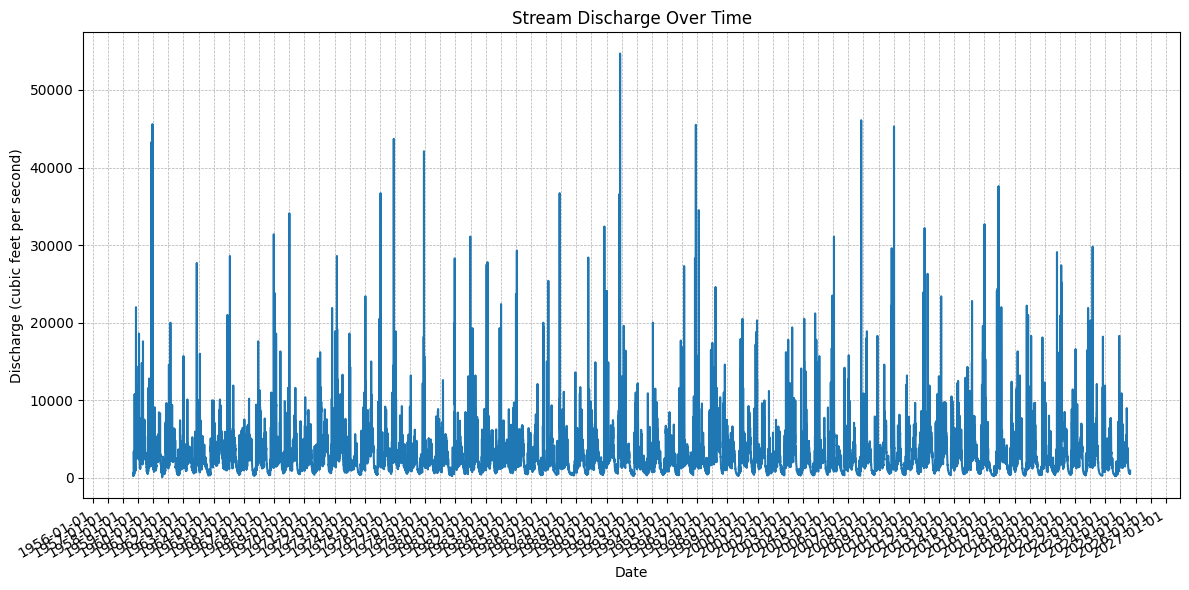

In [4]:
plot_data(data);

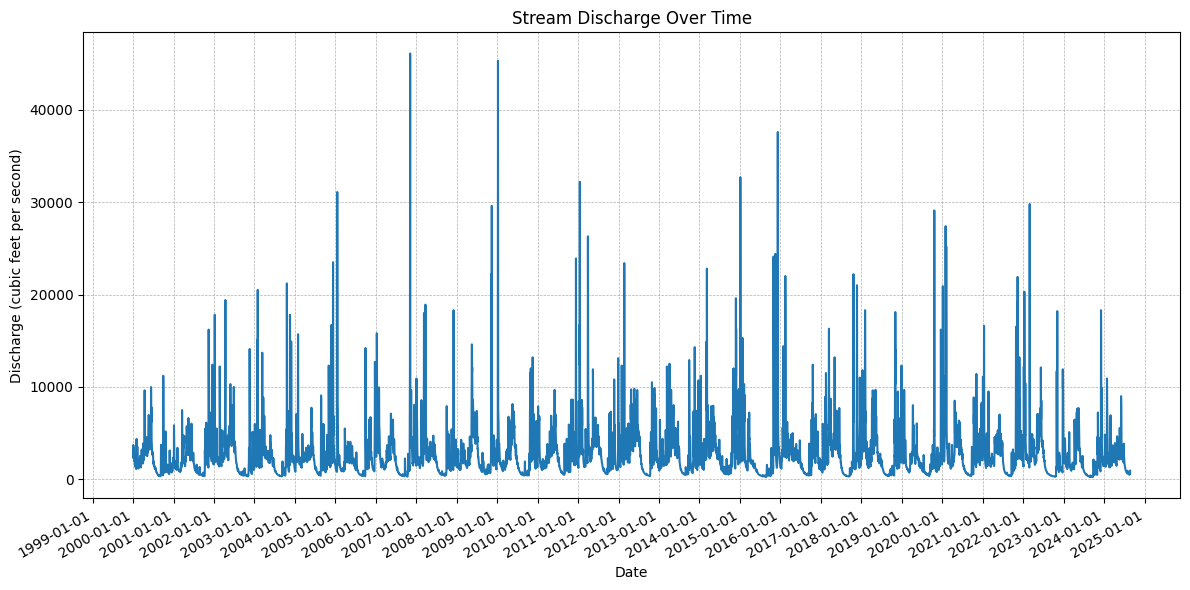

In [5]:
plot_data(data, start_date='2000-01-01', end_date='2024-08-24');

## Plot the data as an array
This better demonstrates the periodicity. But also demonstrates yearly differences in timing of the seasonal extremes. This will likely be challenging for the model.

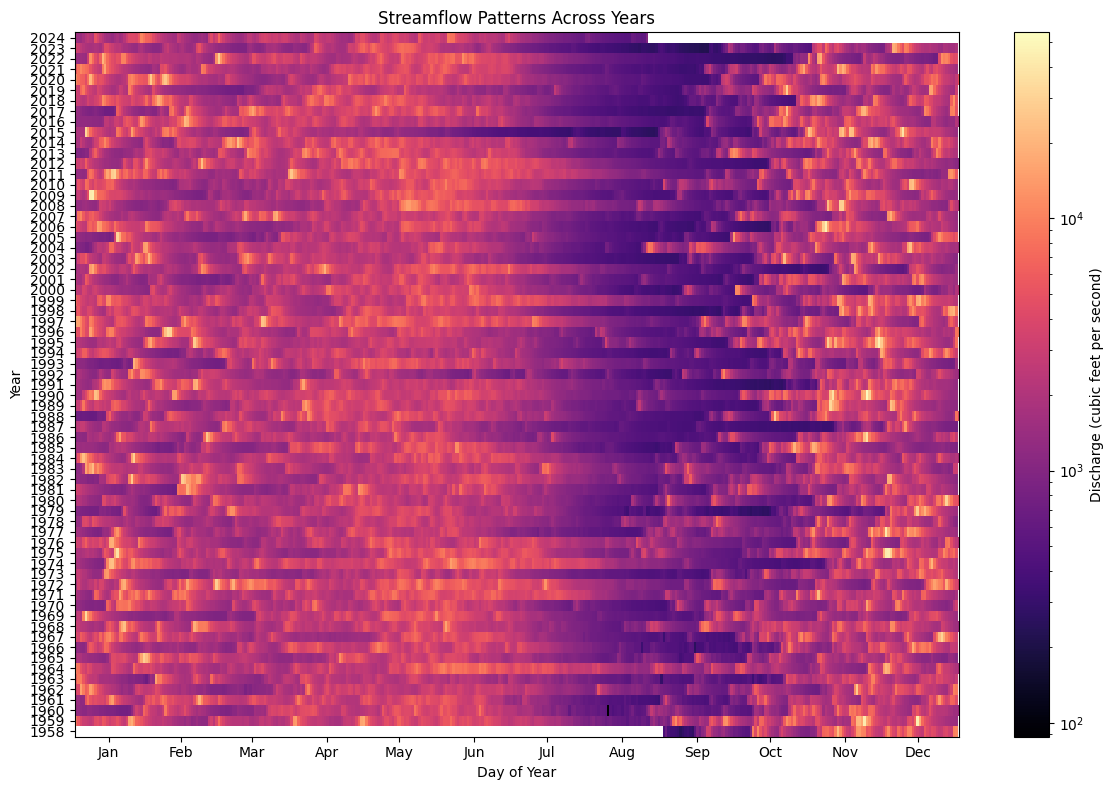

In [6]:
plot_data_as_array(data);

Plot again with defined ranges to better emphasize the differences across years (avoiding letting extreme mins/maxes define the range)

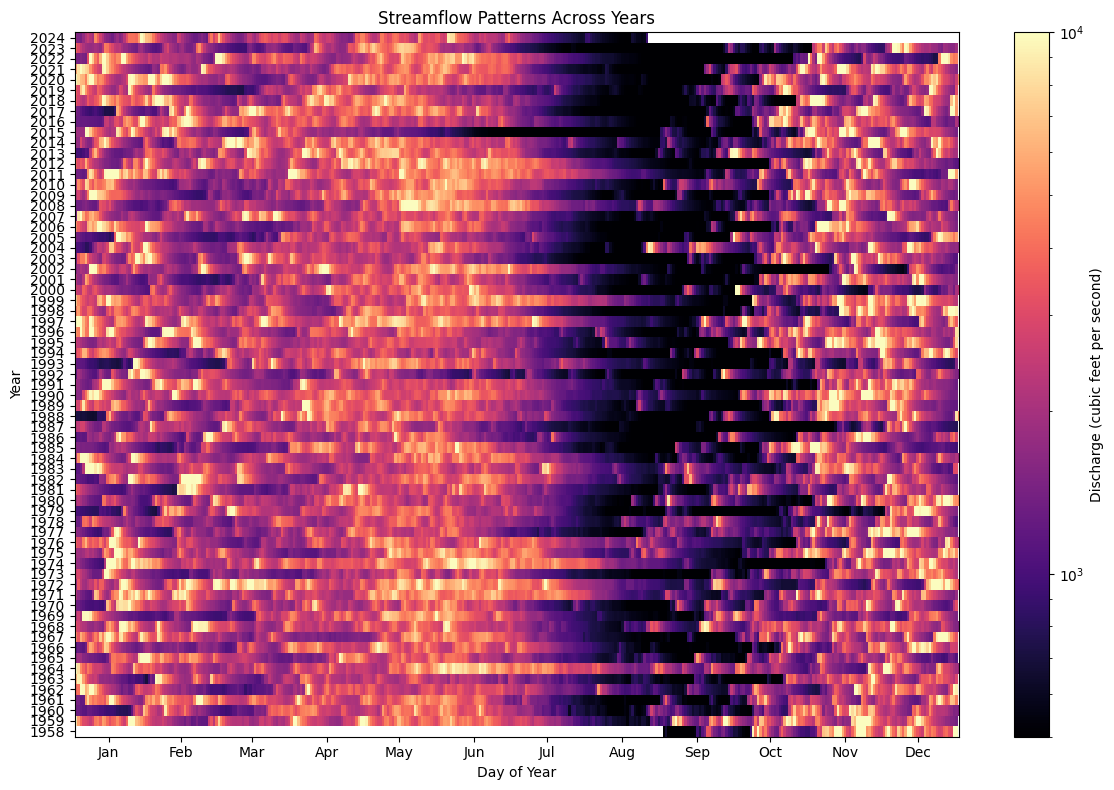

In [7]:
plot_data_as_array(data, vmin=500, vmax=10000);

## Plot the average for each day with 95% confidence intervals. This better demonstrates the seasonal pattern

<Axes: xlabel='day_of_year', ylabel='discharge_cfs'>

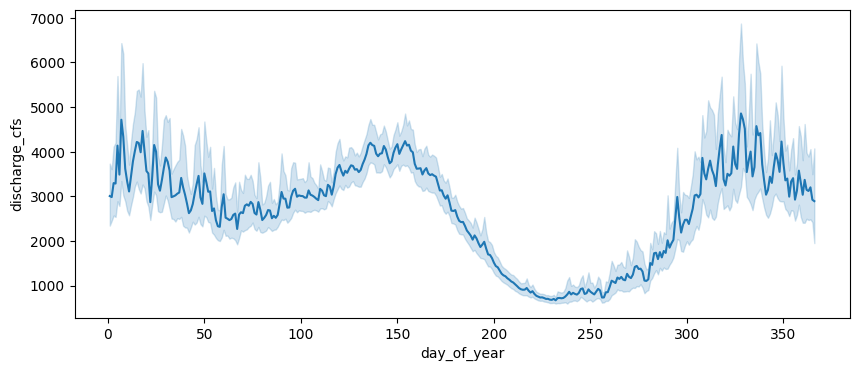

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(
    data = data,
    x='day_of_year',
    y='discharge_cfs',
    ax=ax,
)

## Now start forecasting!
The authors provide a nice pipeline class that performs all of the scaling, quantizing, tokenization, prediction, and decoding. 

I'm going to try out the "small" and "base" models to see how differently they perform.

In [9]:
pipeline_small = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [10]:
pipeline_base = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [15]:
pipeline_large = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

/tmp/ipykernel_1504/1684021893.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(data[data.index <= input_date]["discharge_cfs"]),


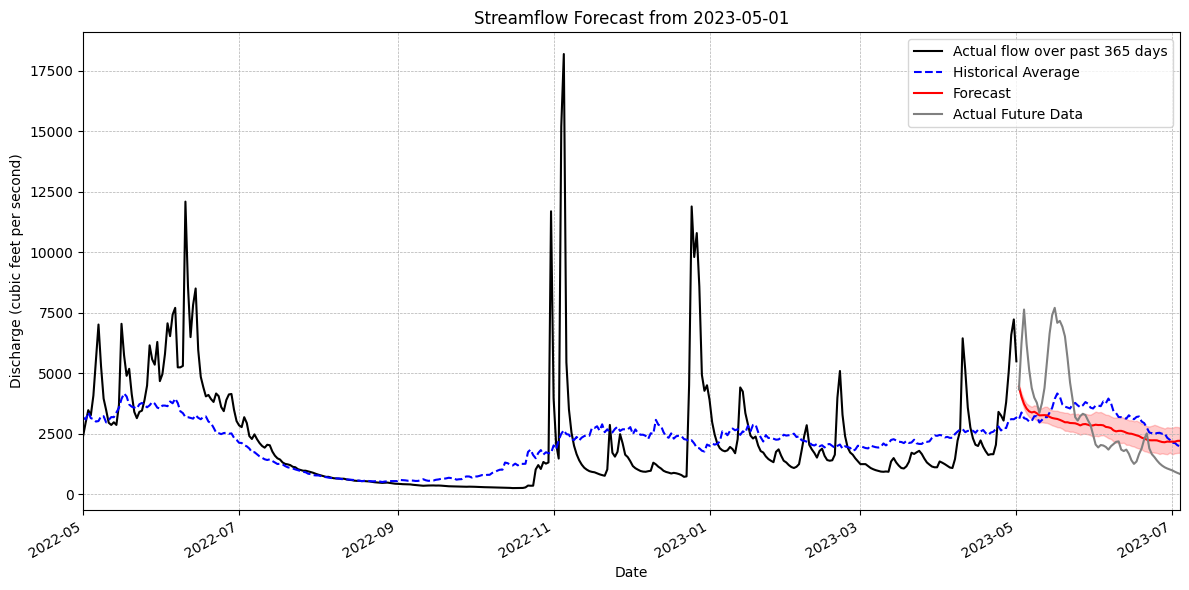

In [12]:
forecast_df = get_forecast_dataframe(
    input_date='2023-05-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_small, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)

/tmp/ipykernel_1504/1684021893.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(data[data.index <= input_date]["discharge_cfs"]),


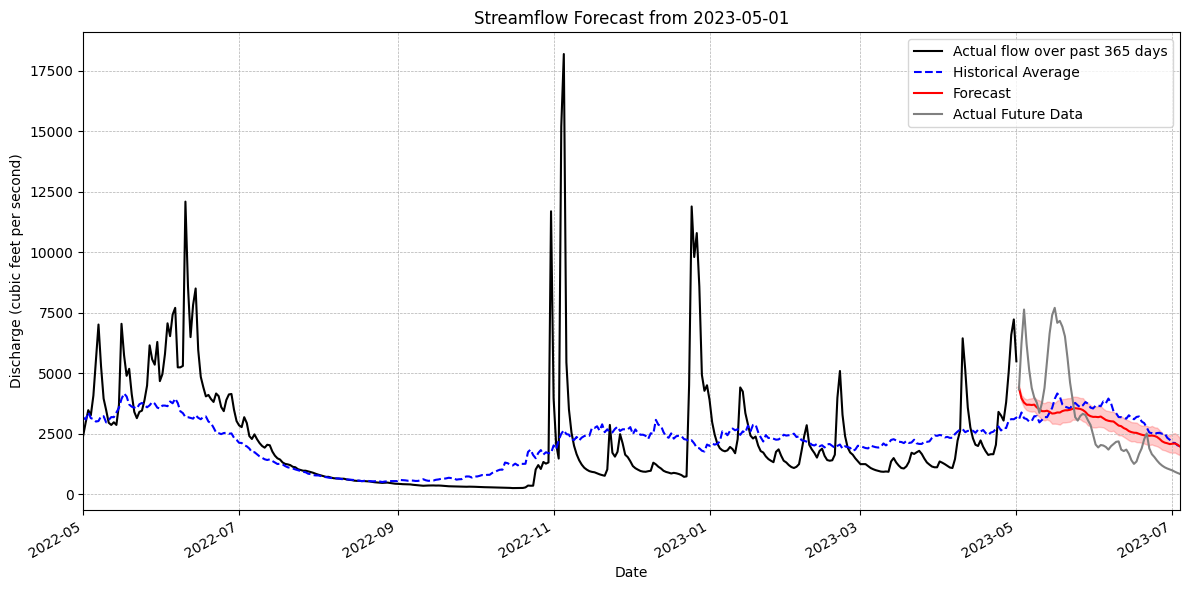

In [13]:
forecast_df = get_forecast_dataframe(
    input_date='2023-05-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_base, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)


/tmp/ipykernel_1504/1684021893.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(data[data.index <= input_date]["discharge_cfs"]),


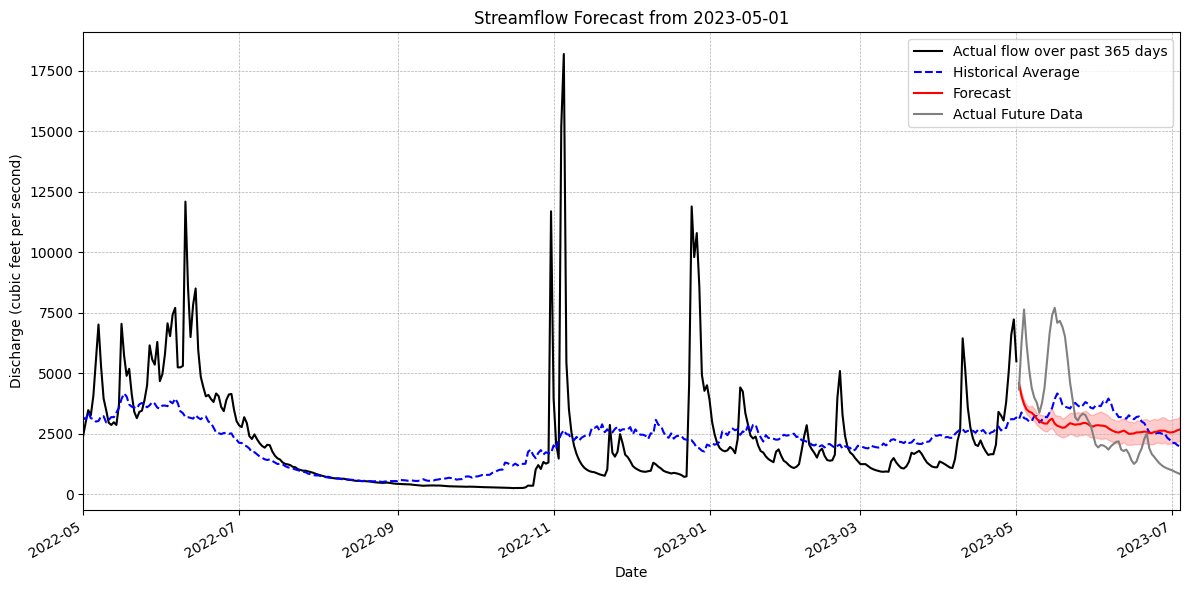

In [16]:
forecast_df = get_forecast_dataframe(
    input_date='2023-05-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_large, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)


/tmp/ipykernel_1504/1684021893.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(data[data.index <= input_date]["discharge_cfs"]),


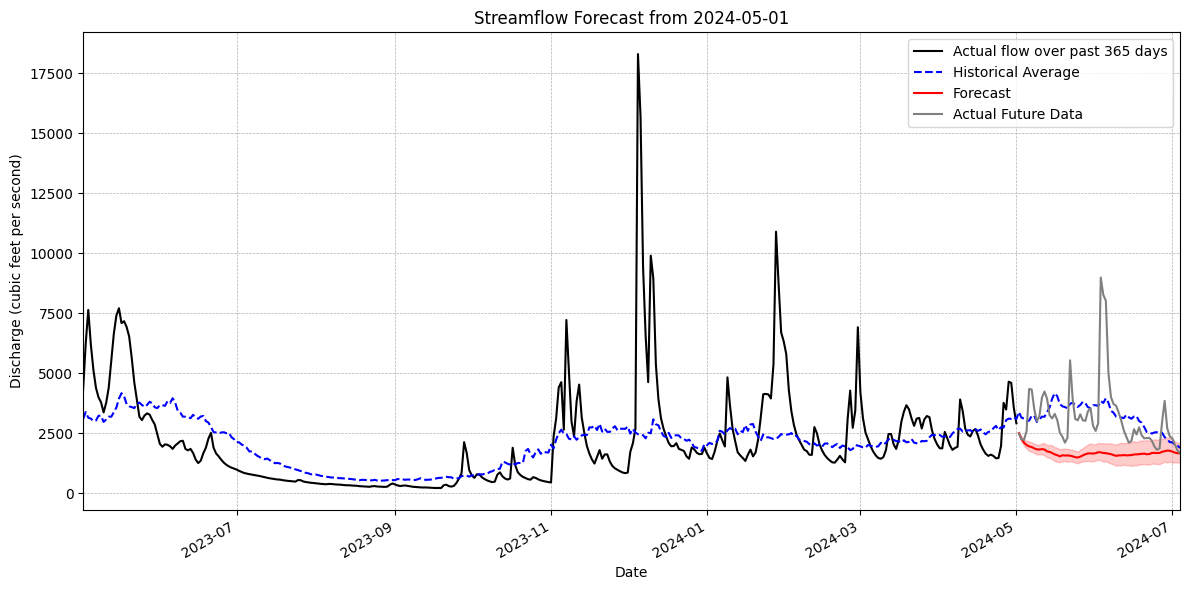

In [17]:
forecast_df = get_forecast_dataframe(
    input_date='2024-05-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_large, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)


/tmp/ipykernel_1504/1684021893.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(data[data.index <= input_date]["discharge_cfs"]),


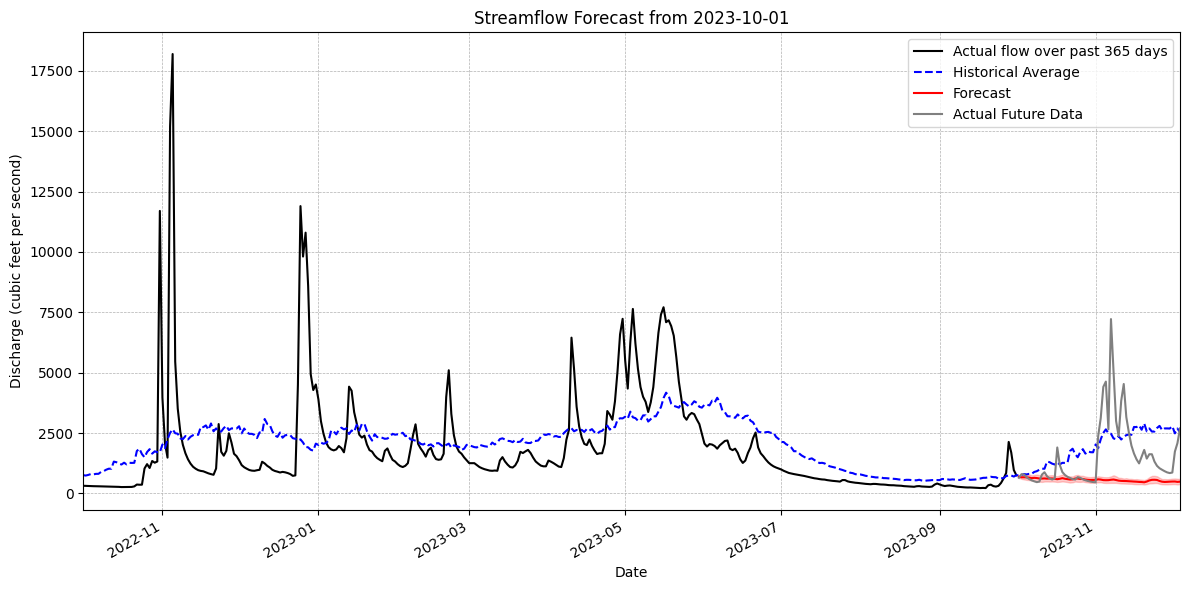

In [18]:
forecast_df = get_forecast_dataframe(
    input_date='2023-10-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_large, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)

/tmp/ipykernel_1504/1684021893.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(data[data.index <= input_date]["discharge_cfs"]),


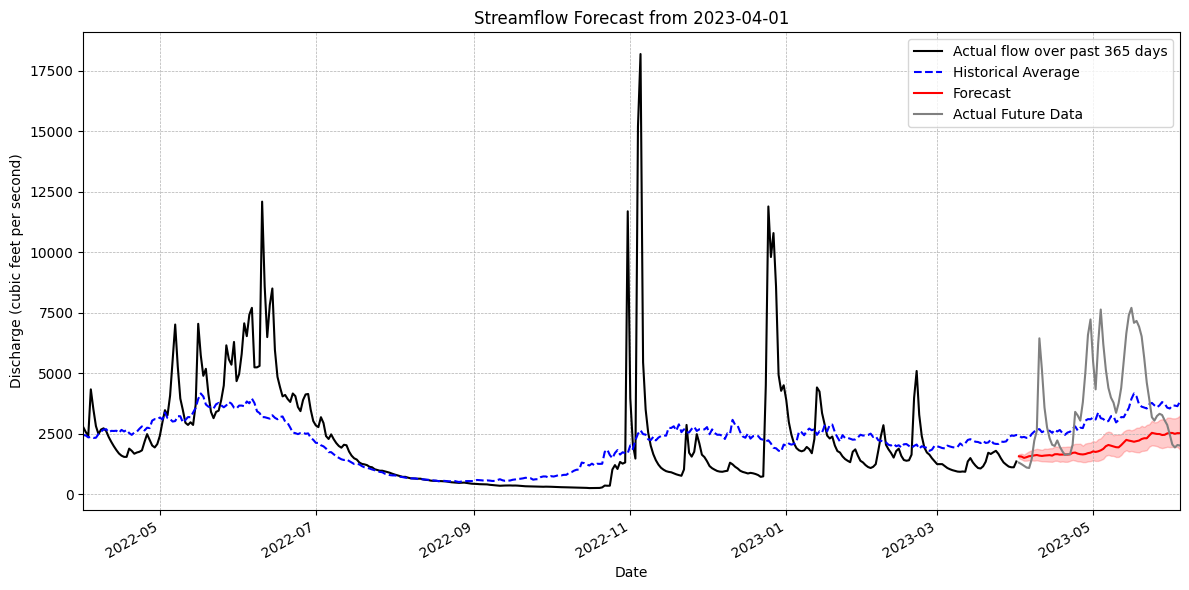

In [19]:
forecast_df = get_forecast_dataframe(
    input_date='2023-04-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_large, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)

/tmp/ipykernel_1504/1684021893.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(data[data.index <= input_date]["discharge_cfs"]),


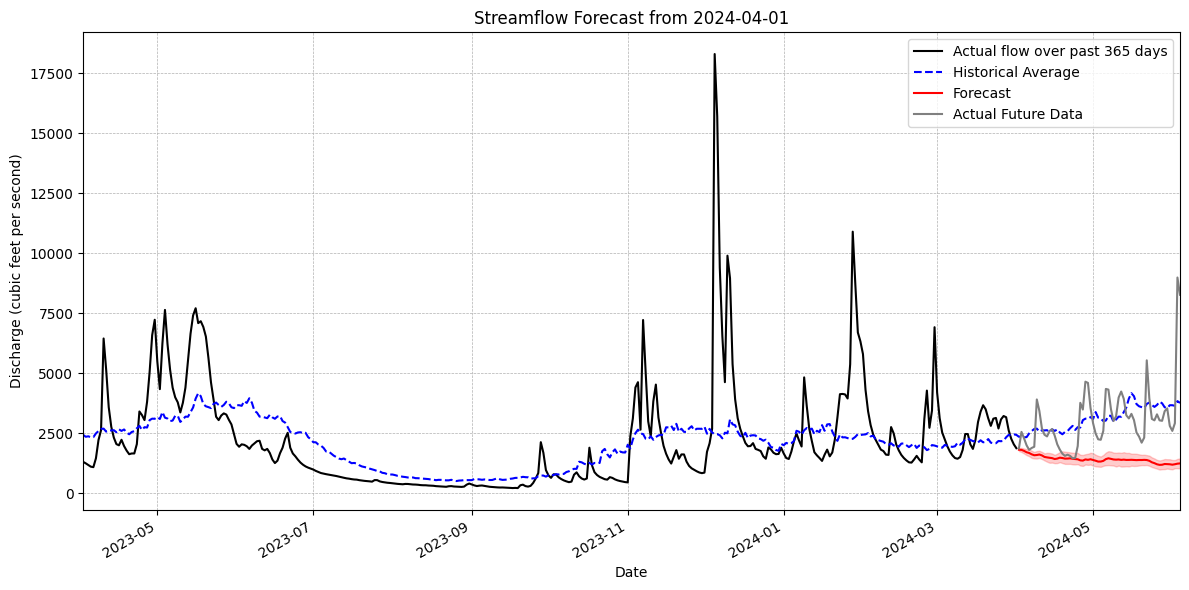

In [20]:
forecast_df = get_forecast_dataframe(
    input_date='2024-04-01', 
    num_samples=30, 
    prediction_length=64, 
    pipeline=pipeline_large, 
    data=data
)

fig, ax = plot_streamflow_forecast(
    data=data, 
    forecast_df=forecast_df,
    history_to_plot=365, 
)